In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from joblib import dump, load

In [2]:
users = pd.read_csv(r"D:\dataset\encoding\user_frame.csv")
user_vectors = pd.read_csv(r"D:\dataset\encoding\user_vectors.csv")
uv_train, uv_test = train_test_split(user_vectors, test_size=0.2, random_state=8)

ratings = pd.read_csv(r"D:\dataset\encoding\ratings_frame.csv")
anime = pd.read_csv(r"D:\dataset\anime_cleaned.csv")

Label encode username column so that usernames can be retrieved after K-Nearest Neighbours calculation

In [3]:
encoder = LabelEncoder()
t_encoder = LabelEncoder()
final_vectors = uv_train.copy()
test_vectors = uv_test.copy()
x = encoder.fit(final_vectors["username"])
t = t_encoder.fit(test_vectors["username"])
#print(encoder.classes_)
username_enc = x.transform(final_vectors["username"])
test_enc = t.transform(test_vectors["username"])

#adding encoded usernames to new dataframe
final_vectors["username"] = username_enc
test_vectors["username"] = test_enc
#pd.set_option('display.max_rows', None)
final_arrays = final_vectors.values
test_arrays = test_vectors.values
#final_vectors.loc[final_vectors["username"]==7537]
#get username from number
#print(encoder.inverse_transform([6490]))
dump(encoder, f"username.pkl")
pd.set_option('display.max_columns', 500)
#final_vectors
#uv_train
#test_arrays
test_vectors
#uv_test
#user_vectors


,username,experience,gender,generation,fav_anime_period,Shounen,Parody,Action,Kids,Dementia,Demons,Comedy,Slice of Life,Super Power,Shoujo Ai,Cars,Harem,Police,Supernatural,Military,Thriller,Martial Arts,Horror,Samurai,Shounen Ai,Psychological,Space,Mystery,Shoujo,Sports,Historical,Josei,Fantasy,Vampire,Seinen,Romance,Ecchi,School,Game,Music,Adventure,Mecha,Magic,Drama,Sci-Fi
3918,581,2,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3195,1505,2,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2234,2703,1,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
7632,775,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
9137,45,3,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9388,2044,1,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3567,3093,1,0,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17657,1892,3,1,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
17760,3609,2,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Compute K-Nearest Neighbours

In [4]:
#function that returns a list of indexes of most similar users in "final_arrays" array
def neighbours(user):
    #user = np.array([7537, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    nc = NearestNeighbors(n_neighbors = 5, metric="cosine") #euclidean
    #maybe add some weightings
    train = nc.fit(final_arrays) #fit the model with the user vector data (training)
    n = train.kneighbors([user], return_distance = False)
    return n

#returns a dataframe of users that were in k-nearest neighbours list 
def sim_frame(neighbours):
    sim_names = []
    #neighbours = neighbours()

    for i in neighbours[0]: #loop through nested array
        #print(final_arrays[i][0])
        name = x.inverse_transform([final_arrays[i][0]]) #find usernames of similar users
        sim_names.append(name)

    #build new dataframe of neighbours
    neighbour_frame = pd.DataFrame()
    for i in users.columns:
        neighbour_frame[i] = None

    for name in sim_names:
        user_row = users.loc[users["username"]==name[0]]
        neighbour_frame = pd.concat([neighbour_frame, user_row])

    pd.options.display.max_rows = 999
    pd.set_option('display.max_columns', 500)
    return neighbour_frame
p = [1675,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]

neighbour_ids = neighbours(np.array(p))
#print(neighbour_ids)
neighbour_frame = sim_frame(neighbour_ids)
neighbour_frame
#final_vectors.loc[final_vectors["username"]==7537]
#(final_vectors.columns)    

,user_id,username,user_completed,stats_mean_score,experience,gender,birth_date,stats_episodes,generation,fav_genres,fav_anime_period
16912,434171,Elysendre,308,8.16,Veteran,Female,1990,7969,Millenials,"['Action', 'Comedy', 'Samurai']",Classic
7977,239521,Fai-chan,675,7.69,Veteran,Female,1993,15193,Millenials,"['Comedy', 'Shoujo', 'School']",New-Gen
8341,3738079,FGokudera,679,7.65,Veteran,Male,1987,12984,Millenials,"['Mystery', 'Seinen', 'Action']",Classic
11877,220879,FBarchitect,117,0.00,Regular,Female,1987,3619,Millenials,"['Romance', 'Shoujo', 'Magic']",Classic
14231,17738,Hei_BK201,589,5.37,Veteran,Male,1983,10852,Millenials,"['Seinen', 'Drama', 'Action']",Classic


Create anime recommendations

In [5]:
#Put anime that have most members at the top of each users "lists"
def recommendations(neighbours, media_type):
    #Get top rated TV shows or movies from each user
    suggestions = [] #anime_id's of recommended anime
    for i in neighbours["username"]:
        user_ratings = ratings.loc[ratings["username"]==i]
        tv_shows = user_ratings[user_ratings["type"]=="TV"]
        movies = user_ratings[user_ratings["type"]=="Movie"]

        if media_type == "TV":
            show_ratings = tv_shows
        else:
            show_ratings = movies
        
        #There may be 0 movies in the user's top 10 list in which case we skip that user's recommendationan
        if len(show_ratings) > 1:
            top_rated = show_ratings.iloc[0]["anime_id"]
            if top_rated not in suggestions:
                suggestions.append(top_rated)
            #print(top_rated)

    if len(suggestions)==0:
        print("No movies to recommend :/")
    return suggestions

recommendations(neighbour_frame, "TV")


#ratings

[28977, 3470, 457, 6114]

Collaborative filtering for additional suggestions

In [6]:
rating_vectors = pd.read_csv(r"D:\dataset\encoding\collab_scores.csv")
anime_frame = pd.read_csv(r"D:\dataset\encoding\anime_frame.csv")
rv_train, rv_test = train_test_split(rating_vectors, test_size=0.2, random_state=1)

In [14]:
def r_neighbours(anime):
    #euclidean #find 2 most similar anime to each of the inital 5 recommendations
    nc = NearestNeighbors(n_neighbors = 2, metric="cosine") 
    train = nc.fit(rv_train.values) #fit the model with the ratings data
    n = train.kneighbors([anime], return_distance = False)
    return n

In [15]:

def r_neighbour_ids(initial):
    n_ids = []
    for r in initial:
        a_vector = list(rating_vectors.loc[rating_vectors["anime_id"]==r].values)
        n_indexes = r_neighbours(a_vector[0])[0]
        #print(n_indexes)
        for i in n_indexes:
            anime_id = rating_vectors.iloc[i]["anime_id"]
            n_ids.append(anime_id)

    #print(n_ids)

    return n_ids
#r_neighbour_ids([30276, 11665, 10162, 1293, 245])   
#user_ratings[user_ratings["type"]=="TV"]
def get_additional_anime(initial):
    more_recs = pd.DataFrame()
    for i in r_neighbour_ids(initial):
        #print(i)
        anime_row = anime_frame.loc[anime_frame["anime_id"]==i]
        #print(anime_row)
        
        more_recs = pd.concat([more_recs, anime_row])
        more_recs = more_recs.loc[:,["anime_id","title","studio", "genre","time_period", "fame"]]
    #exclude the first anime (the show being compared to)
    #more_recs=more_recs[1:]
    return list(more_recs["anime_id"])
#get_additional_anime()


In [16]:
import time
from time import perf_counter
#sample_user = [1675,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
sample_user = [3093,1,0,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
def full_recommendations(target):
    #Initial anime recommendations
    start_time = time.perf_counter()
    k_user_ids = neighbours(target)
    k_neighbour_frame = sim_frame(k_user_ids)
    main_recs = recommendations(k_neighbour_frame,"TV")
    #print(main_recs)
    #Additional anime recommendations
    more_anime = get_additional_anime(main_recs)
    end_time = time.perf_counter()
    #print(f"Execution time for singular user: {np.around((end_time-start_time),2)}s")
    return main_recs, more_anime
full_recommendations(sample_user)

([2251, 2034, 143, 1482, 21],
 [11843, 608, 4720, 21395, 627, 1688, 4795, 713, 459, 31344])

In [17]:
real_ratings = pd.read_csv(r"D:\dataset\animelists_cleaned.csv", nrows = 8000000)

In [18]:
user_fav_genres = eval(users.loc[users["username"]=="karthiga"]["fav_genres"][0])
user_fav_genres

['Comedy', 'Romance', 'Shoujo']

Evaluate recommended anime for users in test set

In [19]:
def evaluate_users(method):
    #Create kneighbours dataframe for all users in the dataset
    overall_scores = []
    num_likes = []
    num_shows_watched = []
    for user in test_arrays:
        user = np.array(user)
        #print([user[0]])
        username = t.inverse_transform([user[0]])[0]
        #print(username)
        user_fav_genres = set(eval(users.loc[users["username"]==username]["fav_genres"].iloc[0]))

        user_neighbours = neighbours(user)
        nframe = sim_frame(user_neighbours)
        #print(user_neighbours)
        content_recs = recommendations(nframe, "TV")
        target_anime = content_recs
        #If we method is collaborative filtering, only evaluate additional recommendations 
        #evaluate raw scores and normalised
        if method == "collab":
            collab_recs = get_additional_anime(content_recs)
            target_anime = collab_recs

        #print(target_anime)
        #Use original ratings dataframe with all shows user has rated instead of simply the top 10
        rt = real_ratings.loc[real_ratings["username"]==username]
        rt = rt.loc[rt["my_watched_episodes"]>3]
        score = 0
        likes = 0
        shows_watched = 0
        #Check whether recommended shows are present in original ratings table
        for show in target_anime:
            a_id = show
            #a_id = int(anime.loc[anime["title"]==show]["anime_id"])

            #Find how many genres in recommended anime are in the user's favourites
            a_genres = list(anime.loc[anime["anime_id"]==a_id]["genre"])
            a_genres = a_genres[0].split(",")
            a_genres = set([x.strip() for x in a_genres])
            #print(a_genres)
            num_matched_genres = len(user_fav_genres.intersection(a_genres)) #max 3 per show = 15
            score+=num_matched_genres
            if int(a_id) in list(rt["anime_id"]): #if user watched the recommended show, give 1 point
                rating_row = real_ratings.loc[(real_ratings["username"]==username)&(real_ratings["anime_id"]==a_id)]
                #print(rating_row)
                shows_watched+=1
                score+=1 #add a point to overall score because user has watched recommended show before
                if int(rating_row["my_score"])>=7:#user "likes" the show if they rated it higher than or equal to 7
                    score+=1 #add an extra point to overall score if the user liked the show
                    likes+=1
        #print(score)    
        #max number of points is 2 x number of neighbours (k): 10 + max amount of matched genres (15)
        #max_score = 25
        num_likes.append(likes)
        overall_scores.append(score)
        num_shows_watched.append(shows_watched)
        #print(f"Score for user {username}: {score}%")

    avg_score = np.around(np.average(overall_scores),decimals=2)
    med_score = np.around(np.median(overall_scores),decimals=2)
    avg_shows_watched = np.around(np.average(num_shows_watched),decimals=2)
    avg_likes = np.around(np.average(num_likes),decimals=2)
    
    print("Satisfaction scores for test users:")
    print(f"Mean score: {avg_score}/50 | {(avg_score/50)*100}%")
    print(f"Median score: {med_score}/50 | {(med_score/50)*100}%")
    print(f"Standard deviation: {np.around(np.std(overall_scores),decimals=2)}")
    print()
    print(f"Mean number of recommended anime that users have watched before: \n{avg_shows_watched} | Standard deviation: {np.around(np.std(num_shows_watched),decimals=2)}")
    print()
    print(f"Mean number of recommended anime that users liked: \n{avg_likes} | Standard deviation: {np.around(np.std(num_likes),decimals=2)}")
    return overall_scores, num_likes, num_shows_watched, avg_score, med_score, avg_shows_watched, avg_likes
    #collab is out of 50
results = evaluate_users("collab") #147minutes

Satisfaction scores for test users:
Mean score: 9.79/50 | 19.58%
Median score: 10.0/50 | 20.0%
Standard deviation: 3.26

Mean number of recommended anime that users have watched before: 
0.5 | Standard deviation: 0.81

Mean number of recommended anime that users liked: 
0.34 | Standard deviation: 0.64


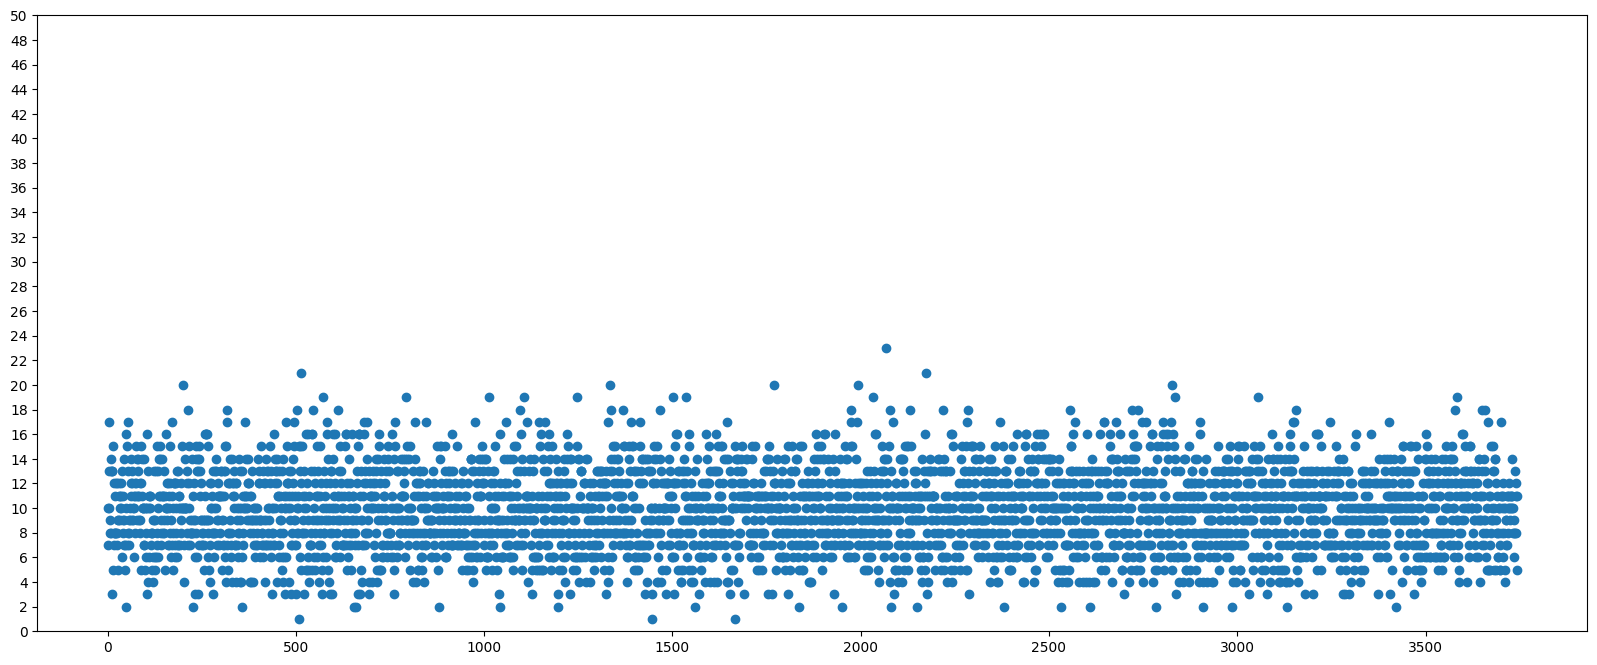

In [22]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
scores = results[0]
x = list(range(1, len(scores)+1))
fig, ax = plt.subplots(figsize=(20,8))

ax.scatter(x, scores)
ax.set_ylim([0,50])
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()
#scores

Filtering anime_frame to be stored in the database

In [ ]:
a = pd.read_csv(r"D:\dataset\encoding\anime_frame.csv")
#t = list(a["genre"])
def string_to_list(genres):
    return eval(genres)
#Building a dictionary of all genres - 43
def split(genres):
    return str(genres).split(",")
a["genre"] = a["genre"].apply(string_to_list)

def test(dataframe):
    #Updating the set to get the individual genre names in the set instead of the original list of genres
    sett = set()
    for i in dataframe: 
        #print(i)
        sett.update(i)
    result = list(sett)
    #print(sett)
    #Removing blank spaces
    final_result = []
    for i in result:
        if i!="nan":
            #new = i.replace(" ", "")
            new = i.strip()
            final_result.append(new)

    #Removing duplicates now that spaces have been removed
    genre_list = list(set(final_result))
    return genre_list
x = test(a["genre"])

#forDB(a["genre"])
#a["genre"]
new_genre = a["genre"].apply(lambda i:str(",".join(i).replace(",","|").replace(" ","")))
new_studio = a["studio"].apply(lambda i:i.replace(",","|"))
a["genre"] = new_genre
#a["genre"]

a["studio"] = new_studio
items = [i for i in range(3057,3240)]
a.iloc[items]
#a.to_csv(r"D:\dataset\encoding\animeDB.csv", index = False)

In [ ]:
id = a["anime_id"]
dir_df = pd.DataFrame(columns=["image"])
l = []
for i in id:
    d = rf"/Content/Assets/anime_covers_large/{i}.jpg"
    l.append(d)
dir_df["image"]=l
dir_df
a["image"]= dir_df
a.to_csv(r"D:\dataset\encoding\animeDB.csv", index = False)
a
#recreate anime db so that file paths are correct